# Space Invaders

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from gym import wrappers, envs
import time

## Baseline: Random Actions

Run a random acting agent through the game to benchmark the 'worst case' benchmark.

In [14]:
env=gym.make('SpaceInvaders-ram-v4')
random_rewards=[]
for i in range(100):
    TotalReward=0
    done=False
    observation=env.reset()
    # Loop until the game ends falls.
    while not done:
        # Choose a random action
        action=env.action_space.sample()
        # Enact the chosen action and recieve a reward.
        observation, reward, done, info = env.step(action)
        TotalReward+=reward
        if done:
            break

    random_rewards.append(TotalReward)
    env.close()

print("Average reward for random actions is:", sum(random_rewards)/len(random_rewards))

Average reward for random actions is: 139.8


## DQN

I am going to try and reuse the cartpole partial DL algorithm here. Note that there are a number of major differences between these two problems that make this probably infeasible. 

1. The cartpole problem rewards the agent for lasting 1 timestep, every timestep and the difference in reward between timesteps is zero. In spaceinvaders we get zero reward for surviving and a positive reward for killing alien ships. Thus a the default strategy is to stay stationary and kill as many alien ships as fast as possible. This sees the totalreward max out at around 290. A better strategy is to delay reward for a few timesteps and opt for a defensive strategy. At present such a strategy is not rewarded sufficiently. Thus under the current strategy total reward maxes out at 285.
2. There should be a negative reward for the loss of a life. However since the state space is a dump of the binary values in ram it is very difficult to ascertain exactly what action lead to the loss of a life. 
3. There are substantial states in the game that require no actions (e.g. the startup and reset after losing a life). How do we treat these states?

In [77]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('SpaceInvaders-ram-v4')

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# Turn interactive mode on.
plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using', device, 'for simulation.')

Using cpu for simulation.


In [78]:
class DQN(nn.Module):
    '''A Deep Q network for predicting actions given states'''
    def __init__(self, inputs, outputs):
        super(DQN, self).__init__()
        # inputs are the 4 vector state space
        self.FCL1 = nn.Linear(128,96)
        self.FCL2 = nn.Linear(96,64)
        self.FCL3 = nn.Linear(64,16)
        self.FCL4 = nn.Linear(16,6)
        # Output is a Q value allocated to each action.
        #
        #       input    hidden   hidden  hidden  output
        #       layer    layer1   layer2  layer3  layer
        #size    128       96       64      16      6

    def forward(self, x):
        x = F.relu(self.FCL1(x))
        x = F.relu(self.FCL2(x))
        x = F.relu(self.FCL3(x))
        x = F.relu(self.FCL4(x))
        return x

In [79]:
'''A mapping of state-action pairs to next-state reward results'''
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):
    '''a cyclic buffer of bounded size that holds recently observed transitions.'''

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            # if we are at less than capacity, allocate fresh space for the transition
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        '''Randomly return a batch of batch_size from the memory'''
        return random.sample(self.memory, batch_size)

    def __len__(self):
        
        return len(self.memory)

In [97]:
BATCH_SIZE = 1024
# Discount Factor
GAMMA = 0.999

# Define epsilon greedy behaviour with 3 parameters.
# Note we want to explore exclusively initially.
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 100.0

# Plot what our epsilon values look like.
#plot_eps(1000,EPS_START,EPS_END,EPS_DECAY)

# How often do we update our policy network parameters (in steps)
TARGET_UPDATE = 10

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get length of state space from gym observation space
n_states = env.observation_space.shape[0]

# Create two networks
policy_net = DQN(n_states, n_actions).to(device)
target_net = DQN(n_states, n_actions).to(device)
# Duplicate the weights and biases of the policy net into the target net.
target_net.load_state_dict(policy_net.state_dict())

target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
# Initialise the memory object.
memory = ReplayMemory(200000)

steps_done = 0


def select_action(state):
    '''??? -> torch
    
    Chooses an epsilon-greedy action given an input state.'''
    global steps_done
    sample = random.random()
    eps_threshold = min(EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY),1.0)
    steps_done += 1
    if sample > eps_threshold:
        # Exploitation
        #print('Exploiting')
        with torch.no_grad():
            
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # Exploration
        #print('Exploring')
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    '''Show the numder of durations per episode on the yaxis.
    After 100 episodes also plot a moving average.
    '''
    plt.figure(2,figsize=(20,10)) 
    #plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 10:
        means = durations_t.unfold(0, 10, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(9), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        #display.display(plt.gcf())

env.close()

In [98]:
def optimize_model():
    '''
    None -> None
    
    Update the DQN policy network via SGD.
    '''
    if len(memory) < BATCH_SIZE:
        print("Warning: We do not have enough history in memory to optimize our network")
        return
    
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))


    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    #                     policy_net(state_batch) 
    #                        outputs the Q(s_t) for all actions. (i.e. a nx2 tensor)
    #                     .gather(1,action_batch) 
    #                         Selects the Q(s_t) value of the action taken
    #                     This gives Q(s_t, a)

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    # THis is a Boolean array with True for non-final states.
    # Question: Why does it need to be cast to a tuple?
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    # This is a float array containing the state values.
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    # Initialise all values as Zero (i.e. all next_states are final.)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    # Update the non-final states with the predicted values from the current value network.
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    ## Zero all gradients
    ### i.e. x.grad =0
    optimizer.zero_grad()
    ## Perform backward pass (calculate dloss/dx for all parameters x.)
    ### i.e x.grad += dloss/dx for all x.
    loss.backward()
    ## Clip Gradients to +/- 1
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    ## Update all parameters.
    ###  i.e. x += -lr * x.grad
    optimizer.step()


Complete


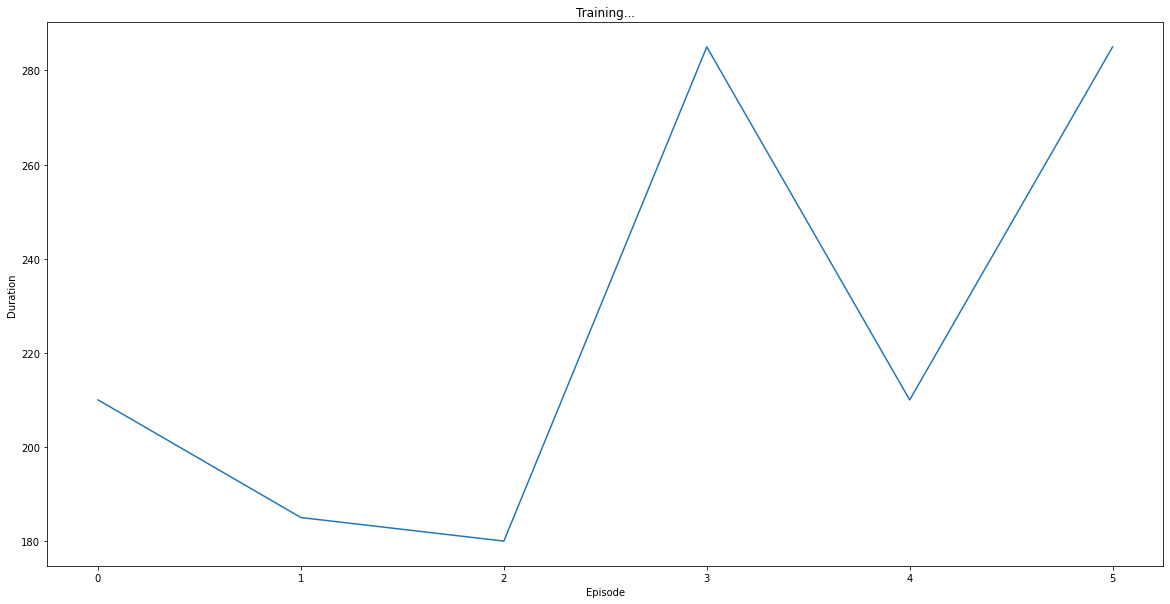

In [102]:
BATCH_SIZE = 1024
# Discount Factor
GAMMA = 0.999

# Define epsilon greedy behaviour with 3 parameters.
# Note we want to explore exclusively initially.
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 400.0

# Plot what our epsilon values look like.
#plot_eps(1000,EPS_START,EPS_END,EPS_DECAY)

# How often do we update our policy network parameters (in steps)
TARGET_UPDATE = 10


num_episodes = 1
for i_episode in range(num_episodes):
    # Initialize the environment and state
    TotalReward=0
    env.reset()
    state, reward, done, _ = env.step(1)
    state = torch.from_numpy(np.cast['float32'](state)).unsqueeze(0).to(device)
    for t in count():
        # Select and perform an action
        action = select_action(state)

        #env.render()
        # Return the environment parameters.
        next_state, reward, done, _ = env.step(action.item())
        next_state = torch.from_numpy(np.cast['float32'](next_state)).unsqueeze(0).to(device)
        TotalReward+=reward
        reward = torch.tensor([reward], device=device)
        
        # If this transition caused the simulation to exit, set the next state to None.
        if not done:
            next_state = next_state
        else:
            # set a strong negative reward for dying
            reward=torch.tensor([-100.], device=device)
            
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        
        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done: #or t >= 5000:
            # Cap simulations at 5000 steps.
            episode_durations.append(TotalReward)
            plot_durations()
            break
            
    if i_episode % TARGET_UPDATE == 0:
        # Update the target network, copying all weights and biases in DQN
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()
plot_durations()

In [91]:
print(env.env.observation_space)

Box(128,)


## DQN with CNNs

Below is the base code I used for the cartpole problem with very little changes. __IT DOES NOT WORK AT PRESENT.__ This is not going to work for a number of reasons:
1. The Spaceinvaders game uses flashing sprites in the GUI meaning that the alien 'bullet' flash in and out of existence. The agent cannot make a rational choice on what do with this. I think I need to stack adjacent frames to remove this flash.
2. The 1 dimensional nature of the cartpole problem means we can contrain the get_screen function to look at only a subset of the screen. In SpaceInvaders we need the top (for Motherships) and the bottom (for player locations). This means that the input the CNN is going to need to be much larger.

In [74]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('SpaceInvaders-ram-v4')

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using', device, 'for simulation.')

Using cpu for simulation.


In [75]:
class DQN(nn.Module):
    '''A Deep Q network to use a CNN to determine Q'''


    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [76]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = C
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

AttributeError: 'AtariEnv' object has no attribute 'x_threshold'

<Figure size 432x288 with 0 Axes>

In [ ]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        #display.display(plt.gcf())

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()


In [ ]:
num_episodes = 200
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()